# pySTED : Python STED microscopy simulator

This tutorial will go over the important parts of pySTED to show the user how to set up an experiment and simulated STED acquisitions.

First, we import the necessary packages

In [1]:
import numpy as np
from pysted import base, utils, raster, bleach_funcs
from matplotlib import pyplot as plt

In order to simulate an acuisition, we need a microscope and a sample. To build the STED microscope, we need an excitation beam, a STED beam, a detector, and objective and some fluorophores (?). Let's make a microscope : the objects that build the microscope and the sample are contained in the pysted.base folder

Setting up the microscope ...
laser array shape = (45, 45)


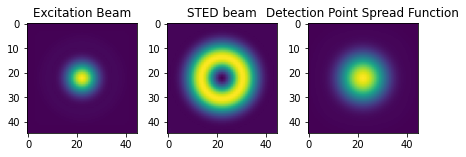

In [12]:
print("Setting up the microscope ...")
# Microscope stuff
egfp = {"lambda_": 535e-9,
        "qy": 0.6,
        "sigma_abs": {488: 1.15e-20,
                      575: 6e-21},
        "sigma_ste": {560: 1.2e-20,
                      575: 6.0e-21,
                      580: 5.0e-21},
        "sigma_tri": 1e-21,
        "tau": 3e-09,
        "tau_vib": 1.0e-12,
        "tau_tri": 5e-6,
        "phy_react": {488: 1e-6,
                      575: 1e-10},
        "k_isc": 0.26e6}

pixelsize = 20e-9
laser_ex = base.GaussianBeam(488e-9)
laser_sted = base.DonutBeam(575e-9)
detector = base.Detector()
objective = base.Objective()
fluo = base.Fluorescence(**egfp)
microscope = base.Microscope(laser_ex, laser_sted, detector, objective, fluo)
i_ex, i_sted, psf_det = microscope.cache(pixelsize)

print(f"laser array shape = {i_ex.shape}")

fig, axes = plt.subplots(1, 3)
axes[0].imshow(i_ex)
axes[0].set_title(f"Excitation Beam")
axes[1].imshow(i_sted)
axes[1].set_title(f"STED beam")
axes[2].imshow(psf_det)
axes[2].set_title(f"Detection Point Spread Function")
plt.tight_layout()
plt.show()
                  

Let's define the important components of the microscope :

pixelsize is the size of a pixel, in meters. Here we use a pixelsize of 20 nm.
base.GaussianBeam(x) creates the excitation laser for the micrscope at given wavelength x. Similarly, base.DonutBeam(y) creates the STED laser for the microscope at given wavelength y. The microscope.cache method generates the lasers and point spread function for the given pixelsize. With a pixelsize of 20nm, our lasers are represented by (45, 45) arrays. If we reduce de pixel size by half, the laser's array size will double :

laser array shape = (91, 91)


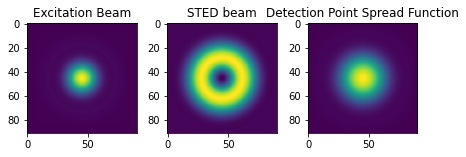

In [3]:
smaller_pixelsize = 10e-9
i_ex_smaller_px, i_sted_smaller_px, psf_det_smaller_px = microscope.cache(smaller_pixelsize)

print(f"laser array shape = {i_ex_smaller_px.shape}")

fig, axes = plt.subplots(1, 3)
axes[0].imshow(i_ex_smaller_px)
axes[0].set_title(f"Excitation Beam")
axes[1].imshow(i_sted_smaller_px)
axes[1].set_title(f"STED beam")
axes[2].imshow(psf_det_smaller_px)
axes[2].set_title(f"Detection Point Spread Function")
plt.tight_layout()
plt.show()

The fluorescence object is built using a bunch of parameters contained in the egfp dictionary

In [4]:
egfp = {"lambda_": 535e-9,
        "qy": 0.6,
        "sigma_abs": {488: 1.15e-20,
                      575: 6e-21},
        "sigma_ste": {560: 1.2e-20,
                      575: 6.0e-21,
                      580: 5.0e-21},
        "sigma_tri": 1e-21,
        "tau": 3e-09,
        "tau_vib": 1.0e-12,
        "tau_tri": 5e-6,
        "phy_react": {488: 1e-7,
                      575: 1e-11},
        "k_isc": 0.26e6}

This dictionary contains values pertaining to the fluorophore used. I will only talk about the most important components instead of going over every parameter. "lambda_" refers to the emission wavelength of the fluorophore. "sigma_abs" and "sigma_ste" are dictionaries mapping laser wavelengths to interaction cross-sections for the excitation and STED beams respectivily. It is important that the excitation wavelength used in the microscope is present in the "sigma_abs" dict, and that the STED wavelength used is present in the "sigma_ste" dict. In our case, we are using an excitation wavelength of 488nm and a STED wavelength of 575nm, so we are all set. Finally, an other important parameter here is the "phy_react" dictionary. This dictionary maps the laser wavelengths to a probability of causing bleaching. Just as previously, it is important that the wavelengths used are present in this dictionnary. I will show later how modifying this parameter affects the acquisition and the resulting bleaching to the sample.

The first thing we need in order to simulate acquisition is simulated data of fluorophores which we want to image. The disposition of the fluorophores is represented by an array, which is then wrapped into a Datamap object. We can create simple Datamaps, or more complex ones.

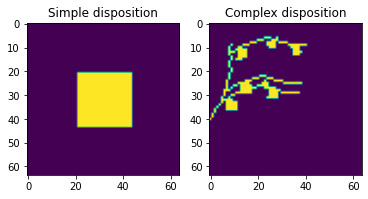

In [5]:
simple_molecules_disposition = np.zeros((64, 64))
simple_molecules_disposition[21:-20, 21:-20] = 5

ensemble, _ = utils.generate_synaptic_fibers((64, 64), (9, 55), (3, 10), (2, 5), seed=27)
complex_molecules_disposition = ensemble.return_frame().astype(int)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(simple_molecules_disposition)
axes[0].set_title(f"Simple disposition")
axes[1].imshow(complex_molecules_disposition)
axes[1].set_title(f"Complex disposition")
plt.show()

Basically, you can shape the datamap however you want to manually, by putting points where you want. For the complex disposition, I use a function which generates fibers and polygons which I will not go into. So if you wanted to do a bunch of experiments on say beads, you could write a function to generate small circles in an array and use that to generate your molecule dispositions

This array then needs to be wrapped into a Datamap object. The Datamap object contains the array's pixel size as well as the region of interest (ROI) that will be imaged in the sample. Setting the ROI allows to better simulate "border effects" (?) that would happen in a real microscopy setting, where fluorophores outside the field of view can still interact with the laser when scanning the edges of the region of the sample. Here, our lasers are 45 by 45 arrays. During acquisition, the lasers will be centered on every position of the ROI, so wee need to make sure the ROI allows the laser to scan the whole ROI without going overboard.

ROI must be within rows [22, 41] inclusively, columns must be within [22, 41] inclusively
Enter a starting row : 22
Enter an ending row : 41
Enter a starting column : 22
Enter an ending column : 41


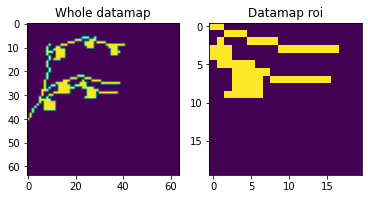

In [6]:
datamap_roi_1 = base.Datamap(complex_molecules_disposition, pixelsize)
# leaving the intervals as None when setting the ROI will promp us to input values and indicate the limits
# based on the shape of the lasers and the molecules_disposition array
datamap_roi_1.set_roi(i_ex, intervals=None)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(datamap_roi_1.whole_datamap)
axes[0].set_title(f"Whole datamap")
axes[1].imshow(datamap_roi_1.whole_datamap[datamap_roi_1.roi])
axes[1].set_title(f"Datamap roi")
plt.show()

If we want to go simpler and simply use the whole molecule_disposition array as ROI, we can pass 'max' for the intervals. This will 0-pad the array so the lasers can fit properly

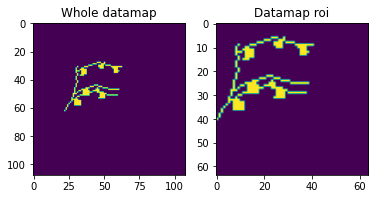

In [7]:
datamap = base.Datamap(complex_molecules_disposition, pixelsize)
# leaving the intervals as None when setting the ROI will promp us to input values and indicate the limits
# based on the shape of the lasers and the molecules_disposition array
datamap.set_roi(i_ex, intervals='max')

fig, axes = plt.subplots(1, 2)
axes[0].imshow(datamap.whole_datamap)
axes[0].set_title(f"Whole datamap")
axes[1].imshow(datamap.whole_datamap[datamap.roi])
axes[1].set_title(f"Datamap roi")
plt.show()

I will use this 0-padded datamap for the rest of the tutorial as I feel it is simpler to visualize and understand, but setting a bigger molecules_disposition array and selecting a smaller ROI within this big array would be more realistic.

We are almost ready to make an acquisition. The final parameters I want to go over before starting an acquisition are the laser powers and the pixel dwell time. These values can either be a singular scalar, in which case the same power/dwell time will be used for every pixel of the ROI, or they can be an array of the same shape as the ROI, in which case we could assing a different value for every pixel of the ROI.

In [30]:
p_ex = 1e-6
p_ex_array = np.reshape(np.linspace(0, 2 * p_ex, num=64*64), (64, 64))
p_sted = 30e-3
p_sted_array = np.reshape(np.linspace(0, 2 * p_sted, num=64*64), (64, 64))
pdt = 10e-6
pdt_array = np.reshape(np.linspace(0, 2 * pdt, num=64*64), (64, 64))


The acquisition function is method of the microscope object, <code>get_signal_and_bleach</code>. The required parameters for this method are a datamap, an acquisition pixelsize, a pixel dwell time, an excitation beam power and a sted beam power. The acquisition pixelsize must be a multiple of the datamap pixel size. If the acquisition pixel size is 3x the datamap pixel size, this means we will only acquire every 3rd pixel. For the sake of simplicity, we will use the same pixelsize as the datamap's pixelsize.
The method returns 3 values : The acquisition array, corresponding to the photon counts, the bleached datamaps, a dictionary containing the resulting bleached sub_datamaps (I will not get into the sub_datamaps right now), and the acquired intensity. The acquired intensity is useful when simulating acquisitions occuring in time where the datamap is also evolving over time, and could evolve mid-acquisitions. For this tutorial, I will ignore the time aspect, so this 3rd returned value will also be ignored.

The optional acquisition parameters include :
bleach : A bool which determines whether bleaching is active or not
update : A bool which determines whether the datamap will be updated in-place after bleaching. It is sometimes              useful to update the datamap in-place, and sometimes it is not. :)
pixel_list : A list of (row, col) tuples which determines the order in which the pixels will be acquired. If None              is passed, a normal raster scan over the ROI will be used (left to right, row by row)
seed : Sets the random seed. There are random processes involved in the acquisition of photons (fluorophores have        a probability of interacting the the lasers) and the bleaching process (fluoropohres have a probability of        bleaching), so setting the random seed can help repeat the same exact experiment with different parameters
       to ensure randomness wasn't causing an observed phenomenon, or to make sure randomness isn't being weird          when debugging. :)

In [13]:
acquisition, bleached, _ = microscope.get_signal_and_bleach(datamap, datamap.pixelsize, pdt, p_ex, p_sted,
                                                            bleach=True, update=False)
bleached_molecules = bleached["base"]

By not updating the datamap in place, we can do multiple acquisitions on the same datamap without affecting to in order to compare the results of different parameter combinations, rather then reinitializing the datamap after every acquisition.

We can also compare the number of molecules before and after the acquisition to quantify how strongly we bleached : 

72.479 % of molecules survived after the acquisition


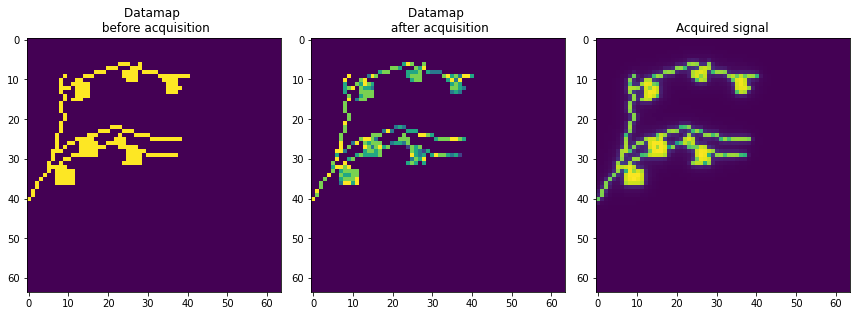

In [16]:
molecules_survival = utils.molecules_survival(datamap.whole_datamap, bleached_molecules)
print(f"{100 * round(molecules_survival, 5)} % of molecules survived after the acquisition")

fig, axes = plt.subplots(1, 3, figsize=(12,8))
axes[0].imshow(datamap.whole_datamap[datamap.roi])
axes[0].set_title(f"Datamap \n before acquisition")
axes[1].imshow(bleached_molecules[datamap.roi])
axes[1].set_title(f"Datamap \n after acquisition")
axes[2].imshow(acquisition)
axes[2].set_title(f"Acquired signal")
plt.tight_layout()

Now let's play around with some parameter values in order to see their effects on the acquisition!

First, let's do a confocal acquisition by setting the p_sted (STED power) to 0.0
(Note : It is important to set it to 0.0 and not 0 as the power needs to be a float for the hidden C function to work correctly with the variable types)

In [19]:
confocal_acquisition, confocal_bleached, _ = microscope.get_signal_and_bleach(datamap, datamap.pixelsize, pdt, 
                                                                              p_ex, p_sted=0.0, bleach=True, 
                                                                              update=False)
confocal_bleached_molecules = confocal_bleached["base"]

94.95700000000001 % of molecules survived after the confocal acquisition


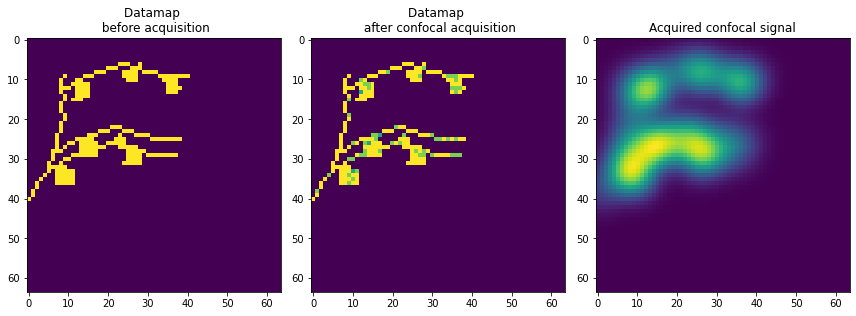

In [20]:
confocal_molecules_survival = utils.molecules_survival(datamap.whole_datamap, confocal_bleached_molecules)
print(f"{100 * round(confocal_molecules_survival, 5)} % of molecules survived after the confocal acquisition")

fig, axes = plt.subplots(1, 3, figsize=(12,8))
axes[0].imshow(datamap.whole_datamap[datamap.roi])
axes[0].set_title(f"Datamap \n before acquisition")
axes[1].imshow(confocal_bleached_molecules[datamap.roi])
axes[1].set_title(f"Datamap \n after confocal acquisition")
axes[2].imshow(confocal_acquisition)
axes[2].set_title(f"Acquired confocal signal")
plt.tight_layout()

As we can see, confocal bleached a lot less than STED, but at the cost of a lower resolution image.

Next I will show acquisitions using an array for the STED laser power. The array goes from 0 W to 0.15 W, increasing constantly from left to right, top to bottom, pixel by pixel. I will do this acquisition on a simple datamap containing evenly spaced dots to show the increasing STED power's effect on the resolution and the bleaching

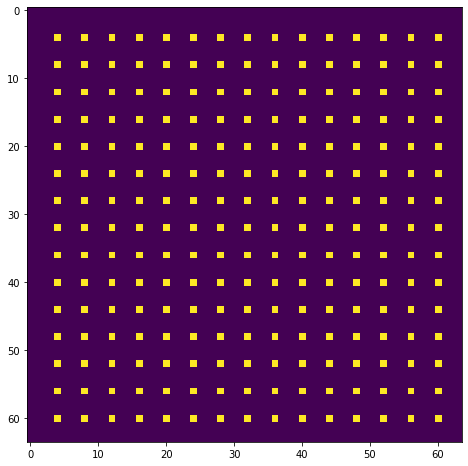

In [33]:
sq_molecules_disposition = np.zeros((64, 64))
molec_positions = []
for row in range(64):
    for col in range(64):
        if (row % 4 == 0) and (row != 0) and (col % 4 == 0) and (col != 0):
            sq_molecules_disposition[row, col] = 5

sq_datamap = base.Datamap(sq_molecules_disposition, pixelsize)
sq_datamap.set_roi(i_ex, intervals='max')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(sq_datamap.whole_datamap[sq_datamap.roi])
plt.show()

In [34]:
inc_sted_acquisition, inc_sted_bleached, _ = microscope.get_signal_and_bleach(sq_datamap, sq_datamap.pixelsize, pdt, 
                                                                              p_ex, p_sted_array, bleach=True, 
                                                                              update=False)
inc_sted_bleached_molecules = inc_sted_bleached["base"]

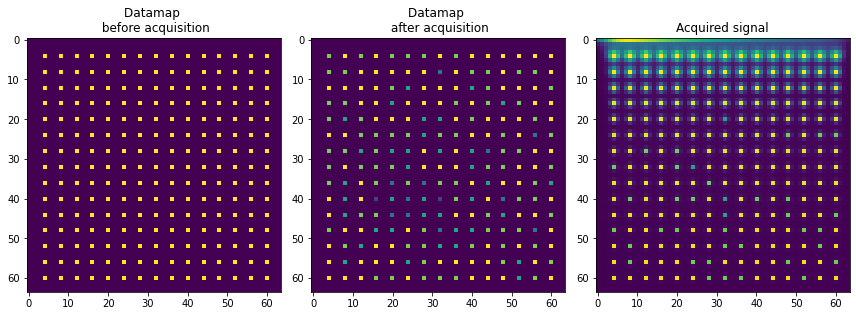

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12,8))
axes[0].imshow(sq_datamap.whole_datamap[datamap.roi])
axes[0].set_title(f"Datamap \n before acquisition")
axes[1].imshow(inc_sted_bleached_molecules[datamap.roi])
axes[1].set_title(f"Datamap \n after acquisition")
axes[2].imshow(inc_sted_acquisition)
axes[2].set_title(f"Acquired signal")
plt.tight_layout()

I mentioned previously how modifying the fluorpohre parameters can impact how much bleaching occurs, so let's show that here :

First we need to create two microscopes, one using a certain set of fluorophore parameters, and a second using using different values.

In [40]:
egfp_low_bleach = {"lambda_": 535e-9,
        "qy": 0.6,
        "sigma_abs": {488: 1.15e-20,
                      575: 6e-21},
        "sigma_ste": {560: 1.2e-20,
                      575: 6.0e-21,
                      580: 5.0e-21},
        "sigma_tri": 1e-21,
        "tau": 3e-09,
        "tau_vib": 1.0e-12,
        "tau_tri": 5e-6,
        "phy_react": {488: 1e-8,
                      575: 1e-12},
        "k_isc": 0.26e6}

egfp_high_bleach = {"lambda_": 535e-9,
        "qy": 0.6,
        "sigma_abs": {488: 1.15e-20,
                      575: 6e-21},
        "sigma_ste": {560: 1.2e-20,
                      575: 6.0e-21,
                      580: 5.0e-21},
        "sigma_tri": 1e-21,
        "tau": 3e-09,
        "tau_vib": 1.0e-12,
        "tau_tri": 5e-6,
        "phy_react": {488: 1e-4, 
                      575: 1e-8},
        "k_isc": 0.26e6}

pixelsize = 20e-9
laser_ex = base.GaussianBeam(488e-9)
laser_sted = base.DonutBeam(575e-9)
detector = base.Detector()
objective = base.Objective()

fluo_low_bleach = base.Fluorescence(**egfp_low_bleach)
microscope_low_bleach = base.Microscope(laser_ex, laser_sted, detector, objective, fluo_low_bleach)

fluo_high_bleach = base.Fluorescence(**egfp_high_bleach)
microscope_high_bleach = base.Microscope(laser_ex, laser_sted, detector, objective, fluo_high_bleach)


In [42]:
acq_low_bleach, low_bleach_bleached, _ = microscope_low_bleach.get_signal_and_bleach(datamap, datamap.pixelsize,
                                                                                     pdt, p_ex, p_sted, 
                                                                                     bleach=True, update=False)
low_bleached_molecules = low_bleach_bleached["base"]

In [44]:
acq_high_bleach, high_bleach_bleached, _ = microscope_high_bleach.get_signal_and_bleach(datamap, datamap.pixelsize,
                                                                                        pdt, p_ex, p_sted,
                                                                                        bleach=True, update=False)
high_bleached_molecules = high_bleach_bleached["base"]

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
